## 📌 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn import *
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import log_loss, mean_absolute_error, brier_score_loss
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

## 📂 2. Load Dataset

In [2]:
# 指定 Kaggle 数据集的路径，使用通配符 ** 以匹配所有文件
path = '/kaggle/input/march-machine-learning-mania-2025/**'

# 使用 glob.glob() 获取 path 下所有符合条件的文件路径
# 通过字典推导式（dict comprehension），以文件名（去掉扩展名）作为键，读取 CSV 并存入字典 data
data = {p.split('/')[-1].split('.')[0] : pd.read_csv(p, encoding='latin-1') for p in glob.glob(path)}

list(data.items())[:2]  # 查看前 2 条数据

[('Conferences',
      ConfAbbrev                                   Description
  0        a_sun                       Atlantic Sun Conference
  1        a_ten                        Atlantic 10 Conference
  2          aac                  American Athletic Conference
  3          acc                     Atlantic Coast Conference
  4          aec                       America East Conference
  5          asc                     American South Conference
  6          awc                      American West Conference
  7     big_east                           Big East Conference
  8    big_eight                          Big Eight Conference
  9      big_sky                            Big Sky Conference
  10   big_south                          Big South Conference
  11     big_ten                            Big Ten Conference
  12  big_twelve                             Big 12 Conference
  13    big_west                           Big West Conference
  14         caa                  Coas

In [3]:
# 合并男子（MTeams）和女子（WTeams）球队数据，形成完整的球队信息表
teams = pd.concat([data['MTeams'], data['WTeams']])

# 合并男子（MTeamSpellings）和女子（WTeamSpellings）球队名称拼写数据
teams_spelling = pd.concat([data['MTeamSpellings'], data['WTeamSpellings']])

# 统计每个 TeamID 对应的不同拼写名称数量
teams_spelling = teams_spelling.groupby(by='TeamID', as_index=False)['TeamNameSpelling'].count()

# 修改列名，明确表示该列表示拼写名称的数量
teams_spelling.columns = ['TeamID', 'TeamNameCount']

# 将拼写统计数据合并到 teams 数据表中，按 TeamID 进行左连接
teams = pd.merge(teams, teams_spelling, how='left', on=['TeamID'])

# 删除不再需要的 teams_spelling 变量，节省内存
del teams_spelling

# 合并男子和女子的常规赛紧凑（Compact）比赛结果
season_cresults = pd.concat([data['MRegularSeasonCompactResults'], data['WRegularSeasonCompactResults']])

# 合并男子和女子的常规赛详细（Detailed）比赛结果
season_dresults = pd.concat([data['MRegularSeasonDetailedResults'], data['WRegularSeasonDetailedResults']])

# 合并男子和女子的 NCAA 锦标赛详细（Detailed）比赛结果
tourney_dresults = pd.concat([data['MNCAATourneyDetailedResults'], data['WNCAATourneyDetailedResults']])

# 合并男子和女子的 NCAA 锦标赛紧凑（Compact）比赛结果
tourney_cresults = pd.concat([data['MNCAATourneyCompactResults'], data['WNCAATourneyCompactResults']])

# 合并男子和女子的 NCAA 锦标赛对阵（Slots）信息
slots = pd.concat([data['MNCAATourneySlots'], data['WNCAATourneySlots']])

# 合并男子和女子的 NCAA 锦标赛种子（Seeds）信息
seeds = pd.concat([data['MNCAATourneySeeds'], data['WNCAATourneySeeds']])

# 构造 seeds_dict 字典，键为 '赛季_球队ID'（如 '2025_1101'），值为种子排名
# 其中 `seeds[['Season', 'Seed', 'TeamID']].values` 提取 Season、Seed、TeamID 三列的值
# int(k1) 确保 Season 为整数，k2 为 TeamID
# v[1:3] 提取种子编号（去掉前缀字符，如 "W01" 取 "01" 并转换为整数）
seeds_dict = {'_'.join(map(str, [int(k1), k2])): int(v[1:3]) for k1, v, k2 in seeds[['Season', 'Seed', 'TeamID']].values}

# 合并男子和女子的比赛城市（Game Cities）信息
gcities = pd.concat([data['MGameCities'], data['WGameCities']])

# 合并男子和女子的赛季信息
seasons = pd.concat([data['MSeasons'], data['WSeasons']])

In [4]:
print(list(seeds_dict.items())[:3])
print(teams.head(5))
seeds.head(5)

[('1985_1207', 1), ('1985_1210', 2), ('1985_1228', 3)]
   TeamID     TeamName  FirstD1Season  LastD1Season  TeamNameCount
0    1101  Abilene Chr         2014.0        2025.0              3
1    1102    Air Force         1985.0        2025.0              2
2    1103        Akron         1985.0        2025.0              1
3    1104      Alabama         1985.0        2025.0              1
4    1105  Alabama A&M         2000.0        2025.0              2


,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


## 🔍 3. Feature Engineering

## 最终得到的表
1. **games 表**（包含历史锦标赛比赛数据）
- 每场比赛的种子排名、种子排名差、得分差、胜负归一化得分差等特征。
- 通过 IDTeams 关联的比赛统计特征（如投篮命中数、篮板等）。
2. **sub 表**（用于预测的新比赛数据）
- 解析 Team1、Team2 并计算相应特征，与 games 结构一致。
- 这两张表为后续模型训练和预测提供了丰富的输入特征。

1. 构造种子排名字典
- 读取种子排名数据，将每支队伍在每个赛季的种子编号存储为字典 { '赛季_队伍ID': 种子编号 }，方便后续查询。
2. 合并和预处理比赛数据
- 读取并合并常规赛和锦标赛的比赛数据，并添加比赛类型标识（S 代表常规赛，T 代表锦标赛）。
- 处理比赛场地信息，将胜利场地编码为数值。
- 生成每场比赛的唯一 ID（赛季_队伍1ID_队伍2ID），用于后续分组统计。

In [5]:
# 构造种子字典 { '赛季_队伍ID': 种子编号 }
seeds = {'_'.join(map(str, [int(k1), k2])): int(v[1:3]) for k1, v, k2 in seeds[['Season', 'Seed', 'TeamID']].values}

# 读取数据集中的城市信息和提交样本
cities = data['Cities']
sub = data['SampleSubmissionStage1']
# 删除 data 变量，释放内存（data 不再需要）
del data

# 给不同类型的比赛数据集添加标识列 'ST'，用于区分赛季比赛（'S'）和锦标赛比赛（'T'）
season_cresults['ST'] = 'S'
season_dresults['ST'] = 'S'
tourney_cresults['ST'] = 'T'
tourney_dresults['ST'] = 'T'

games = pd.concat((season_dresults, tourney_dresults), axis=0, ignore_index=True)
games.reset_index(drop=True, inplace=True)
games['WLoc'] = games['WLoc'].map({'A': 1, 'H': 2, 'N': 3})

# 在这里r就是一个形参代表每一行的数据

# 生成比赛的唯一 ID，格式为 '赛季_队伍1ID_队伍2ID'（无论谁赢）
games['ID'] = games.apply(lambda r: '_'.join(map(str, [r['Season']] + sorted([r['WTeamID'], r['LTeamID']]))), axis=1)
games['IDTeams'] = games.apply(lambda r: '_'.join(map(str, sorted([r['WTeamID'], r['LTeamID']]))), axis=1)

3. 规范化比赛数据
- 确保 Team1 和 Team2 统一格式，始终让编号较小的队伍为 Team1，较大的为 Team2，以便数据一致性。
- 生成 Team1 和 Team2 的种子排名，若无种子信息则默认 0。
- 计算比赛的得分差（胜者得分 - 败者得分）。
- 确定 Team1 是否为比赛胜者，并计算标准化得分差（如果 Team1 输了，则取反）。
- 计算两队的种子排名差（Team1 的种子排名 - Team2 的种子排名）。
- 填充数据中的缺失值（-1 处理）。

In [6]:

# 确定比赛中编号较小的队伍作为 Team1，较大的作为 Team2
games['Team1'] = games.apply(lambda r: sorted([r['WTeamID'], r['LTeamID']])[0], axis=1)
games['Team2'] = games.apply(lambda r: sorted([r['WTeamID'], r['LTeamID']])[1], axis=1)

# 生成队伍赛季唯一 ID，例如 '2025_1101' 代表 2025 赛季的队伍 1101
games['IDTeam1'] = games.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team1']])), axis=1)
games['IDTeam2'] = games.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team2']])), axis=1)

# 使用之前创建的 seeds 字典填充每个队伍的种子排名，未找到则默认为 0
games['Team1Seed'] = games['IDTeam1'].map(seeds).fillna(0)
games['Team2Seed'] = games['IDTeam2'].map(seeds).fillna(0)

# 计算比赛分差
games['ScoreDiff'] = games['WScore'] - games['LScore']

# 计算胜利队是否是 Team1
games['Pred'] = games.apply(lambda r: 1. if sorted([r['WTeamID'], r['LTeamID']])[0] == r['WTeamID'] else 0., axis=1)

# 计算规范化的得分差，如果胜队是 Team2，则取反
games['ScoreDiffNorm'] = games.apply(lambda r: r['ScoreDiff'] * -1 if r['Pred'] == 0. else r['ScoreDiff'], axis=1)

# 计算种子排名差
games['SeedDiff'] = games['Team1Seed'] - games['Team2Seed']

# 将数据中的空值填充为 -1
games = games.fillna(-1)

4. 构造比赛统计特征
- 选取多个比赛数据指标（如投篮命中、篮板、失误等），按**两队 ID 组合（IDTeams）**进行聚合计算，提取各项统计特征（总和、均值、中位数、最大值、最小值、标准差、偏度、不同值个数等）。
- 处理列名，使其变得直观易读。

In [7]:
# 定义需要计算统计特征的比赛数据列
c_score_col = ['NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl',
 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl',
 'LBlk', 'LPF']

# 定义要计算的统计量（聚合操作）：总和、均值、中位数、最大值、最小值、标准差、偏度、不同值个数
c_score_agg = ['sum', 'mean', 'median', 'max', 'min', 'std', 'skew', 'nunique']
           
# 按照 'IDTeams'（两队的ID组合）分组，计算比赛统计数据的聚合信息
gb = games.groupby(by=['IDTeams']).agg({k: c_score_agg for k in c_score_col}).reset_index()
  
# 由于进行聚合后，每一列的名称变成了一个多级索引（例如 ('WFGM', 'sum')），这里将列名合并成单个字符串
gb.columns = [''.join(c) + '_c_score' for c in gb.columns]

# 仅保留锦标赛（'T' 表示比赛类型为锦标赛，'S' 为常规赛）
games = games[games['ST'] == 'T']

In [8]:
gb

,IDTeams_c_score,NumOTsum_c_score,NumOTmean_c_score,NumOTmedian_c_score,NumOTmax_c_score,NumOTmin_c_score,NumOTstd_c_score,NumOTskew_c_score,NumOTnunique_c_score,WFGMsum_c_score,...,LBlkskew_c_score,LBlknunique_c_score,LPFsum_c_score,LPFmean_c_score,LPFmedian_c_score,LPFmax_c_score,LPFmin_c_score,LPFstd_c_score,LPFskew_c_score,LPFnunique_c_score
0,1101_1102,0,0.0,0.0,0,0,NaN,NaN,1,23,...,NaN,1,14,14.000000,14.0,14,14,NaN,NaN,1
1,1101_1115,0,0.0,0.0,0,0,NaN,NaN,1,24,...,NaN,1,19,19.000000,19.0,19,19,NaN,NaN,1
2,1101_1116,0,0.0,0.0,0,0,0.0,NaN,1,53,...,NaN,2,40,20.000000,20.0,21,19,1.414214,NaN,2
3,1101_1117,0,0.0,0.0,0,0,0.0,NaN,1,59,...,NaN,1,48,24.000000,24.0,24,24,0.000000,NaN,1
4,1101_1122,0,0.0,0.0,0,0,NaN,NaN,1,29,...,NaN,1,23,23.000000,23.0,23,23,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40179,3474_3480,0,0.0,0.0,0,0,0.0,NaN,1,36,...,NaN,2,47,23.500000,23.5,24,23,0.707107,NaN,2
40180,3475_3478,0,0.0,0.0,0,0,NaN,NaN,1,31,...,NaN,1,8,8.000000,8.0,8,8,NaN,NaN,1
40181,3476_3478,0,0.0,0.0,0,0,0.0,0.0,1,150,...,1.369306,3,80,13.333333,13.0,19,8,3.669696,0.184816,5
40182,3476_3479,0,0.0,0.0,0,0,0.0,NaN,1,50,...,NaN,2,32,16.000000,16.0,17,15,1.414214,NaN,2


5. 处理提交数据
- 解析提交样本（预测比赛的队伍信息），并按与 games 数据相同的方式提取 Team1、Team2、种子排名、种子排名差 等特征。
6. 合并统计特征
- 将比赛数据的统计特征合并到 games 和 sub 表，确保模型可以利用历史数据进行预测。
7. 筛选最终特征
- 从 games 表中去除无关列（如比赛 ID、胜负信息等），保留用于建模的特征。

In [9]:
# 处理比赛数据
sub['WLoc'] = 3
sub['Season'] = sub['ID'].map(lambda x: x.split('_')[0])
sub['Season'] = sub['ID'].map(lambda x: x.split('_')[0])
sub['Season'] = sub['Season'].astype(int)
sub['Team1'] = sub['ID'].map(lambda x: x.split('_')[1])
sub['Team2'] = sub['ID'].map(lambda x: x.split('_')[2])
sub['IDTeams'] = sub.apply(lambda r: '_'.join(map(str, [r['Team1'], r['Team2']])), axis=1)
sub['IDTeam1'] = sub.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team1']])), axis=1)
sub['IDTeam2'] = sub.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team2']])), axis=1)
sub['Team1Seed'] = sub['IDTeam1'].map(seeds).fillna(0)
sub['Team2Seed'] = sub['IDTeam2'].map(seeds).fillna(0)
sub['SeedDiff'] = sub['Team1Seed'] - sub['Team2Seed'] 
sub = sub.fillna(-1)

games = pd.merge(games, gb, how='left', left_on='IDTeams', right_on='IDTeams_c_score')
sub = pd.merge(sub, gb, how='left', left_on='IDTeams', right_on='IDTeams_c_score')
#如果某列名不在这两个列表里，就保留它。
col = [c for c in games.columns if c not in ['ID', 'DayNum', 'ST', 'Team1', 'Team2', 'IDTeams', 'IDTeam1', 'IDTeam2', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'NumOT', 'Pred', 'ScoreDiff', 'ScoreDiffNorm', 'WLoc'] + c_score_col]

## 📊 4. Data Visualization

### 4.1 Win Distribution by Seed Matchups
- 核心目的是 分析 NCAA 比赛中不同种子之间的胜负关系。
- 先获取种子信息，再统计胜负数据，最后用 热力图 直观展示不同种子对战的胜场分布

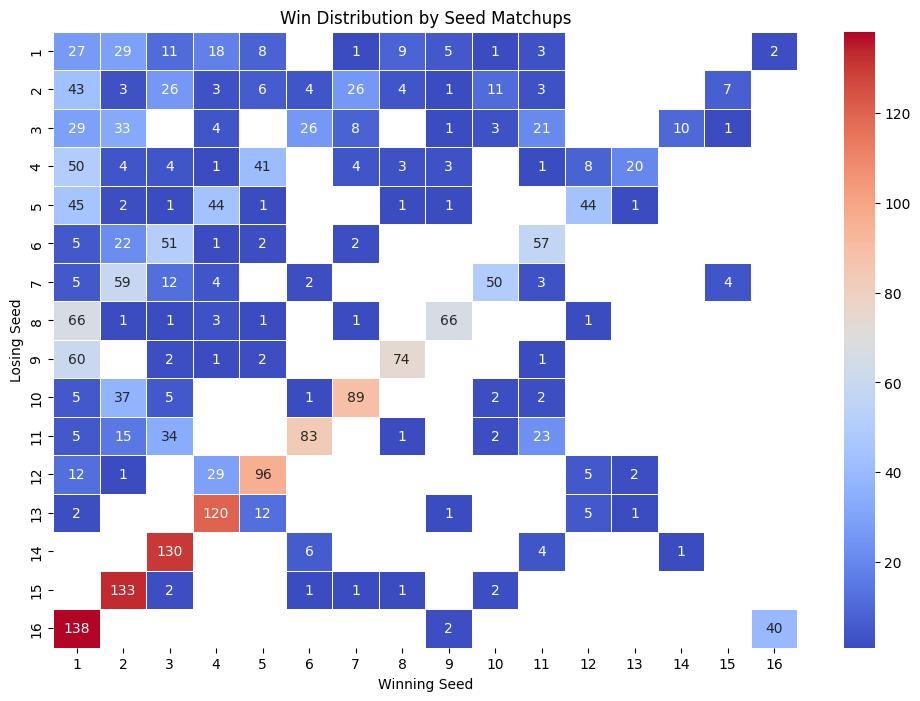

In [10]:
tourney_dresults['WSeed'] = tourney_dresults.apply(lambda r: seeds_dict.get(f"{r['Season']}_{r['WTeamID']}", np.nan), axis=1)
tourney_dresults['LSeed'] = tourney_dresults.apply(lambda r: seeds_dict.get(f"{r['Season']}_{r['LTeamID']}", np.nan), axis=1)
tourney_dresults['Seed_Diff'] = tourney_dresults['WSeed'] - tourney_dresults['LSeed']

seed_win_counts = tourney_dresults.groupby(['WSeed', 'LSeed']).size().reset_index(name='WinCount')
plt.figure(figsize=(12, 8))
heatmap_data = seed_win_counts.pivot(index='LSeed', columns='WSeed', values='WinCount')
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".0f", linewidths=0.5)

plt.title("Win Distribution by Seed Matchups")
plt.xlabel("Winning Seed")
plt.ylabel("Losing Seed")
plt.show()

### 4.2 Score Distribution of Winning & Losing Teams

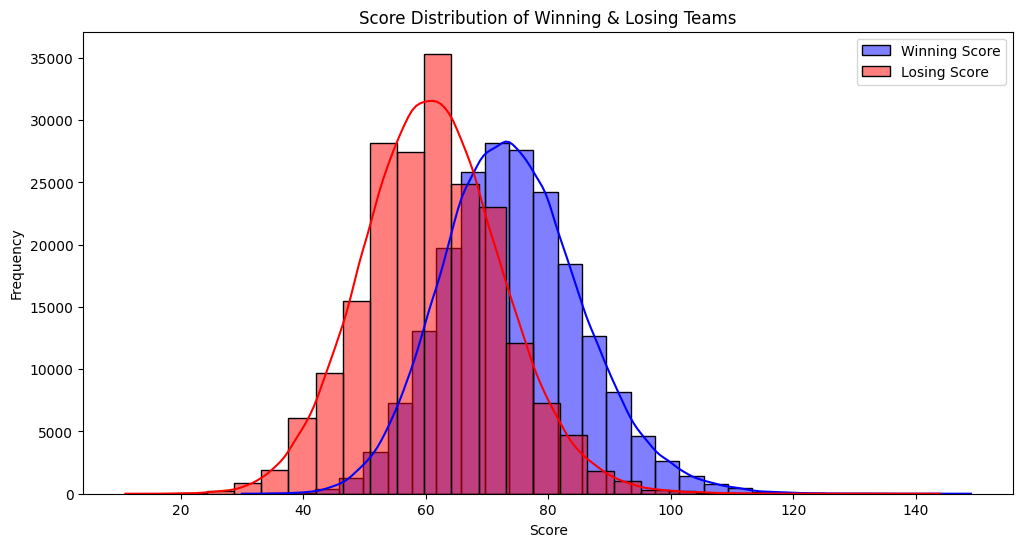

In [11]:
plt.figure(figsize=(12,6))
sns.histplot(season_dresults['WScore'], bins=30, kde=True, color='blue', label='Winning Score')
sns.histplot(season_dresults['LScore'], bins=30, kde=True, color='red', label='Losing Score')
plt.legend()
plt.title("Score Distribution of Winning & Losing Teams")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

### 4.3 Win Rate by Seed

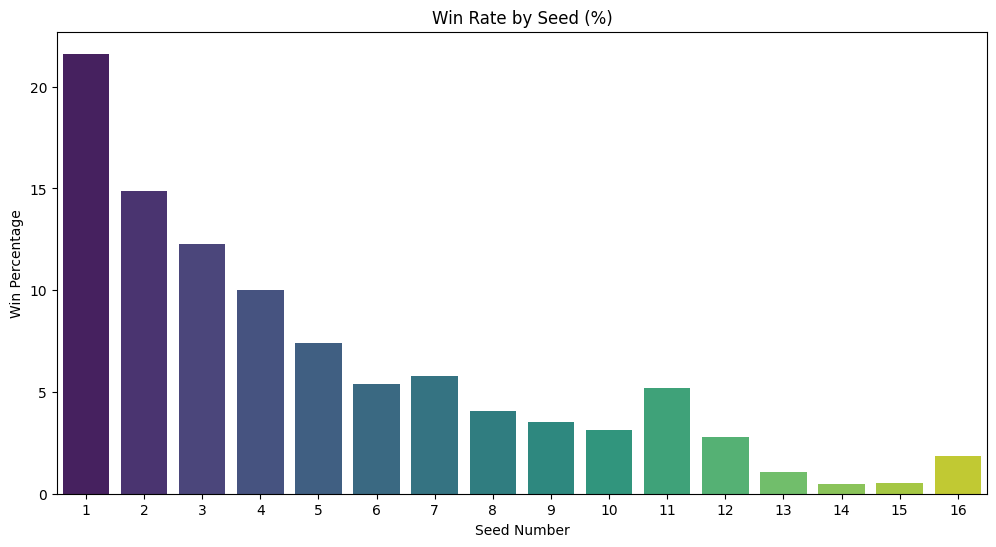

In [12]:
seed_win_rate = tourney_dresults.groupby('WSeed').size() / tourney_dresults.groupby('WSeed').size().sum() * 100
plt.figure(figsize=(12, 6))
sns.barplot(x=seed_win_rate.index, y=seed_win_rate.values, palette="viridis")
plt.title("Win Rate by Seed (%)")
plt.xlabel("Seed Number")
plt.ylabel("Win Percentage")
plt.show()

### 4.4 Seed Difference vs. Winning Seed

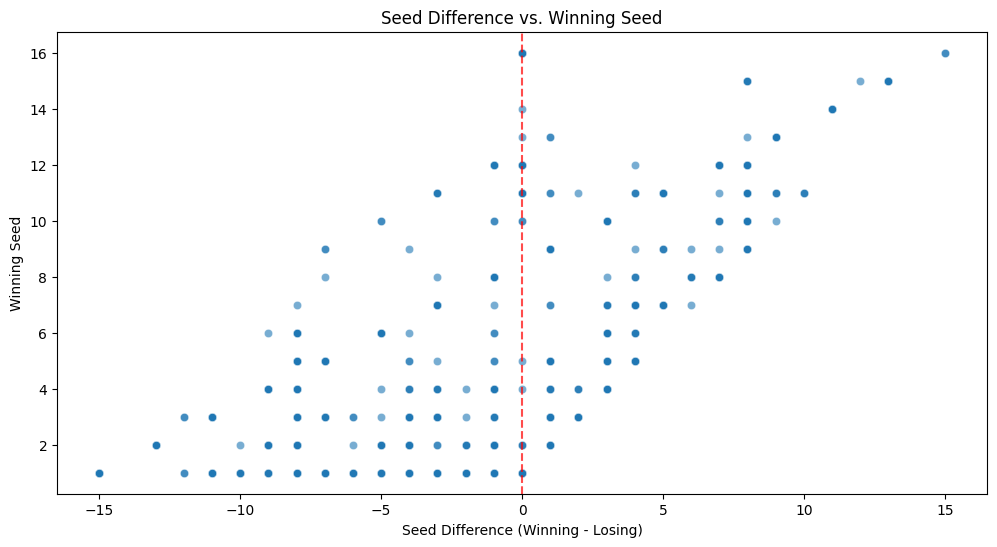

In [13]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=tourney_dresults['Seed_Diff'], y=tourney_dresults['WSeed'], alpha=0.6)
plt.title("Seed Difference vs. Winning Seed")
plt.xlabel("Seed Difference (Winning - Losing)")
plt.ylabel("Winning Seed")
plt.axvline(0, linestyle="--", color="red", alpha=0.7)  # Highlight equal seeds
plt.show()

### 4.5 Upset Rate Over the Years (Lower Seed Wins

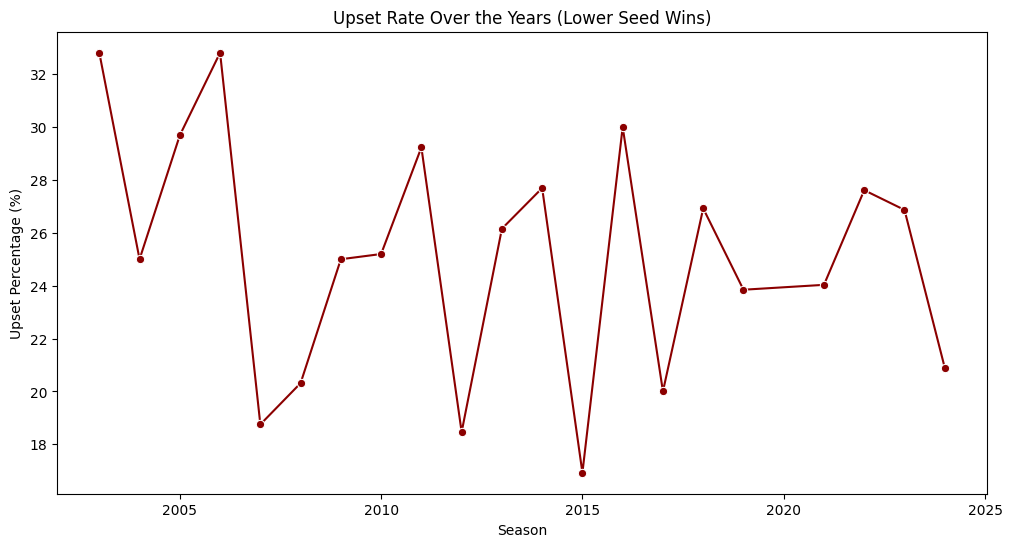

In [14]:
tourney_dresults['Upset'] = (tourney_dresults['Seed_Diff'] > 0).astype(int)  # 1 if lower seed wins
upset_rate_per_year = tourney_dresults.groupby('Season')['Upset'].mean() * 100
plt.figure(figsize=(12, 6))
sns.lineplot(x=upset_rate_per_year.index, y=upset_rate_per_year.values, marker="o", color="darkred")
plt.title("Upset Rate Over the Years (Lower Seed Wins)")
plt.xlabel("Season")
plt.ylabel("Upset Percentage (%)")
plt.show()

### 4.6 Winning & Losing Score Distribution Over Years

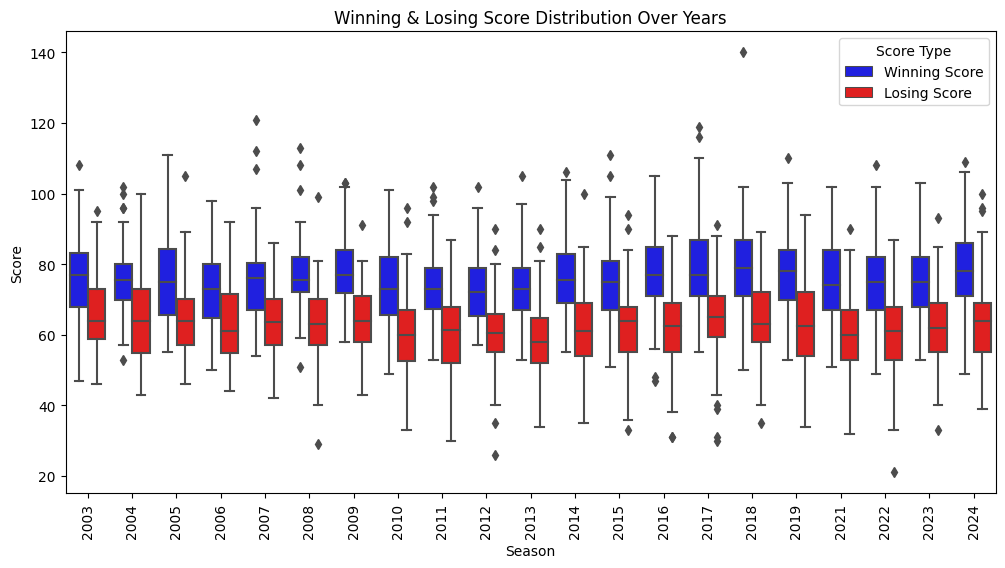

In [15]:
plt.figure(figsize=(12, 6))
tourney_dresults_melted = tourney_dresults.melt(id_vars=['Season'], value_vars=['WScore', 'LScore'], 
                                                var_name="Winner/Loser", value_name="Score")
sns.boxplot(data=tourney_dresults_melted, x='Season', y='Score', hue="Winner/Loser", 
            palette={"WScore": "blue", "LScore": "red"})  
plt.title("Winning & Losing Score Distribution Over Years")
plt.xlabel("Season")
plt.ylabel("Score")
plt.xticks(rotation=90)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ["Winning Score", "Losing Score"], title="Score Type")
plt.show()

### 4.7 Average Winning Score Difference Over Years

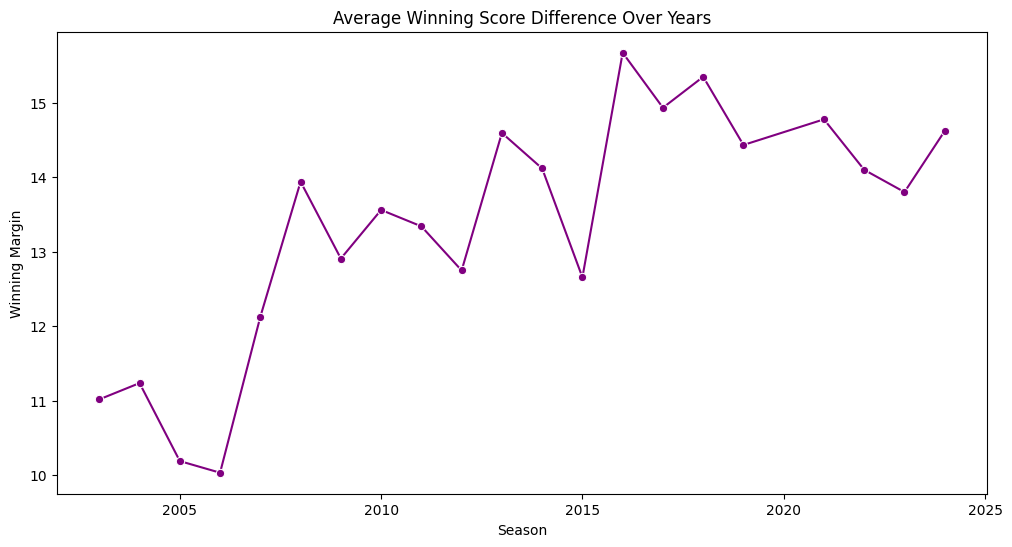

In [16]:
tourney_dresults['Score_Diff'] = tourney_dresults['WScore'] - tourney_dresults['LScore']
score_diff_trend = tourney_dresults.groupby('Season')['Score_Diff'].mean()
plt.figure(figsize=(12, 6))
sns.lineplot(x=score_diff_trend.index, y=score_diff_trend.values, marker="o", color="purple")
plt.title("Average Winning Score Difference Over Years")
plt.xlabel("Season")
plt.ylabel("Winning Margin")
plt.show()

### 4.8 Top 15 Most Successful Teams (Based on Tournament Wins)

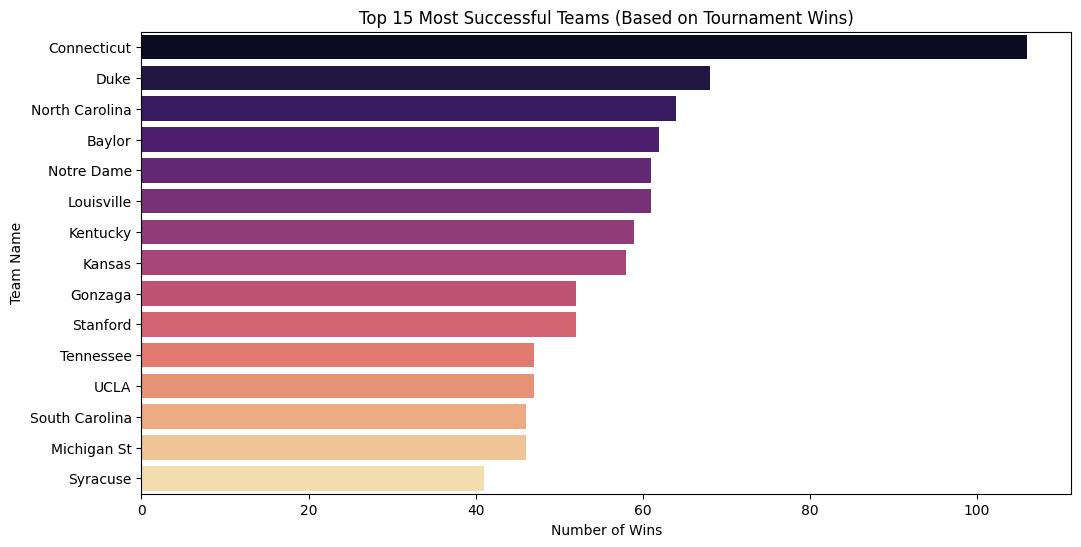

In [17]:
tourney_dresults = tourney_dresults.merge(teams, left_on='WTeamID', right_on='TeamID', how='left')
tourney_dresults = tourney_dresults.rename(columns={'TeamName': 'WinningTeam'})
tourney_dresults = tourney_dresults.merge(teams, left_on='LTeamID', right_on='TeamID', how='left')
tourney_dresults = tourney_dresults.rename(columns={'TeamName': 'LosingTeam'})
team_win_counts = tourney_dresults['WinningTeam'].value_counts().head(15)
plt.figure(figsize=(12, 6))
sns.barplot(x=team_win_counts.values, y=team_win_counts.index, palette="magma")
plt.title("Top 15 Most Successful Teams (Based on Tournament Wins)")
plt.xlabel("Number of Wins")
plt.ylabel("Team Name")
plt.show()

### 4.9 Cinderella Stories - Most Wins by Low Seeded Teams

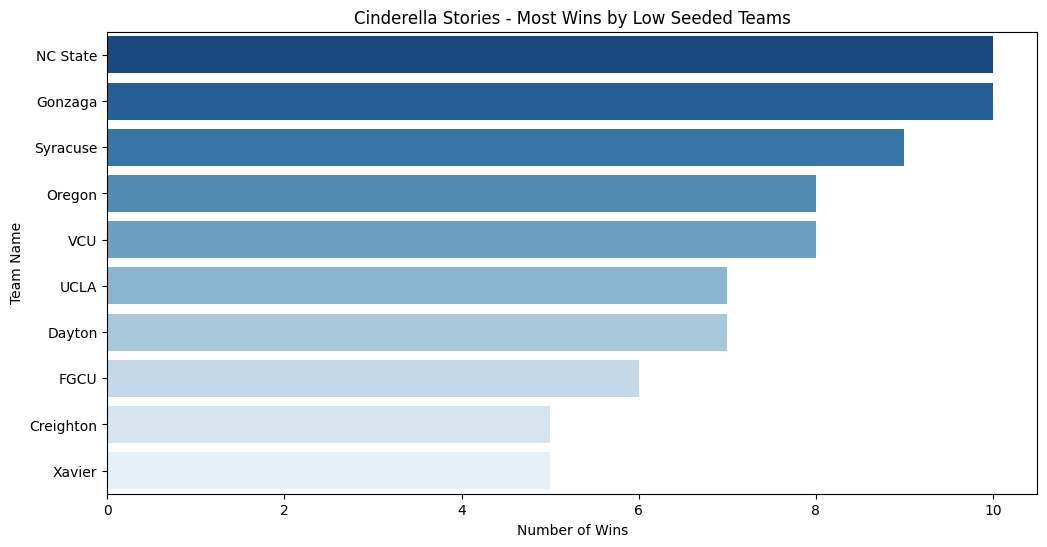

In [18]:
cinderella_teams = tourney_dresults[tourney_dresults['WSeed'] >= 10]['WinningTeam'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=cinderella_teams.values, y=cinderella_teams.index, palette="Blues_r")
plt.title("Cinderella Stories - Most Wins by Low Seeded Teams")
plt.xlabel("Number of Wins")
plt.ylabel("Team Name")
plt.show()

## 🚀 5. Train XGBoost Model

In [19]:
imputer = SimpleImputer(strategy='mean')  
scaler = StandardScaler()

X = games[col].fillna(-1)
missing_cols = set(col) - set(sub.columns)
for c in missing_cols:
    sub[c] = 0

X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)

xgb = XGBRegressor(n_estimators=5000,device="gpu", learning_rate=0.03, max_depth=6, random_state=42)
xgb.fit(X_scaled, games['Pred'])

pred = xgb.predict(X_scaled).clip(0.001, 0.999)

print(f'Log Loss: {log_loss(games["Pred"], pred)}')
print(f'Mean Absolute Error: {mean_absolute_error(games["Pred"], pred)}')
print(f'Brier Score: {brier_score_loss(games["Pred"], pred)}')

cv_scores = cross_val_score(xgb, X_scaled, games['Pred'], cv=5, scoring='neg_mean_squared_error')
print(f'Cross-validated MSE: {-cv_scores.mean()}')

Log Loss: 0.0016103502659381632
Mean Absolute Error: 0.0016074318599171922
Brier Score: 5.809199331997511e-06
Cross-validated MSE: 0.206776918498559


## 📤 6. Create Submission File

In [20]:
sub_X = sub[col].fillna(-1)
sub_X_imputed = imputer.transform(sub_X)
sub_X_scaled = scaler.transform(sub_X_imputed)

sub['Pred'] = xgb.predict(sub_X_scaled).clip(0.001, 0.999)
sub[['ID', 'Pred']].to_csv('submission.csv', index=False)

In [21]:
df = pd.read_csv("/kaggle/input/march-machine-learning-mania-2025/SampleSubmissionStage2.csv")
df = df[['ID']]
df


,ID
0,2025_1101_1102
1,2025_1101_1103
2,2025_1101_1104
3,2025_1101_1105
4,2025_1101_1106
...,...
131402,2025_3477_3479
131403,2025_3477_3480
131404,2025_3478_3479
131405,2025_3478_3480


In [22]:
sub[sub['ID'].str.contains('3477_3480', na=False)][['ID', 'Pred']]


,ID,Pred


In [23]:
# 1️⃣ 从 sub 提取队伍对 (去掉年份)
sub['TeamPair'] = sub['ID'].apply(lambda x: '_'.join(x.split('_')[1:]))  # 提取 "1101_1102"

# 2️⃣ 对相同的队伍对计算 2021-2024 赛季的平均预测值
sub_avg = sub.groupby('TeamPair')['Pred'].mean().reset_index()

sub_avg

,TeamPair,Pred
0,1101_1102,0.498822
1,1101_1103,0.462011
2,1101_1104,0.550687
3,1101_1105,0.154821
4,1101_1106,0.154821
...,...,...
131398,3475_3477,0.130736
131399,3475_3478,0.594699
131400,3476_3477,0.130736
131401,3476_3478,0.481163


In [24]:
# 3️⃣ 从 df 提取 2025 年的队伍对 (去掉 2025_)
df['TeamPair'] = df['ID'].apply(lambda x: '_'.join(x.split('_')[1:]))

# 4️⃣ 进行匹配，把 2021-2024 赛季的预测平均值赋给 2025 年的比赛
df = df.merge(sub_avg, on='TeamPair', how='left')

df=df[['ID','Pred']]

In [25]:
df

,ID,Pred
0,2025_1101_1102,0.498822
1,2025_1101_1103,0.462011
2,2025_1101_1104,0.550687
3,2025_1101_1105,0.154821
4,2025_1101_1106,0.154821
...,...,...
131402,2025_3477_3479,NaN
131403,2025_3477_3480,NaN
131404,2025_3478_3479,NaN
131405,2025_3478_3480,NaN


In [26]:
# 5️⃣ 处理缺失值（如果有些队伍组合在 2021-2024 年没有数据，你可以填充 0.5）
df['Pred'] = df['Pred'].fillna(0.5)

# 6️⃣ 保留提交格式
submission = df[['ID', 'Pred']]

# 7️⃣ 保存 CSV 提交
submission.to_csv('submission.csv', index=False)